In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sys
from scipy.stats import multivariate_normal

# Add the parent directory of simpleparameterisation to the sys.path list
sys.path.append('../')

# Now you can import simpleparameterisation from the new location
import TPCevt as TPC

det = TPC.Detector("Simple TPC with Atmospheric Ar (default values)")


In [3]:
# Initial Parameter
pitch_x = 0.1
pitch_y = 0.1
pitch_z = 0.1
std = det.PSFstd = 1
thresh = 1e-20
grid_size = 500
rv = multivariate_normal([0,0,0], np.diag([std, std, std]))

In [16]:
# Function Definition
def getDistribution(grid_size, offset):
    x, y, z = np.mgrid[-grid_size*pitch_x:(grid_size+1)*pitch_x:pitch_x,
            -grid_size*pitch_y:(grid_size+1)*pitch_y:pitch_y,
            -grid_size*pitch_z:(grid_size+1)*pitch_z:pitch_z,
            ]
    offset_x, offset_y, offset_z = offset

    gain = np.random.exponential(scale=det.gain_mean)
    # top_right = np.stack((np.array([x+pitch_x/2-offset_x, y+pitch_y/2-offset_y])), axis=-1)
    # bottom = np.stack((np.array([x+pitch_x/2-offset_x, y-pitch_y/2-offset_y])), axis=-1)
    # left = np.stack((np.array([x-pitch_x/2-offset_x, y+pitch_y/2-offset_y])), axis=-1)
    # bottom_left = np.stack((np.array([x-pitch_x/2-offset_x, y-pitch_y/2-offset_y])), axis=-1)
    val = rv.pdf(np.stack((x, y, z), axis = -1))*pitch_x*pitch_y*pitch_z*gain
    # gain=1 #not considering gain effect for temporary

    # val_cdf = (rv.cdf(top_right) - rv.cdf(bottom) - rv.cdf(left) + rv.cdf(bottom_left))*gain

    # plt.figure()
    # plt.title('Val CDF')
    # plt.scatter(x, y, c=val_cdf)
    # plt.xlim(-5, 5)
    # plt.ylim(-5, 5)
    # plt.colorbar()
    return x, y, z, val

def applyThreshold(x_1, y_1, z_1, readout_1, thresh):
    mask_1 = readout_1 >= thresh
    x_1_filtered = x_1[mask_1].flatten()
    y_1_filtered = y_1[mask_1].flatten()
    z_1_filtered = z_1[mask_1].flatten()
    
    readout_1_filtered = readout_1[mask_1]
    return x_1_filtered, y_1_filtered, z_1_filtered, readout_1_filtered


def filterCoord(x, y, z, val, minvals, maxvals):
    filtered_x = []
    filtered_y = []
    filtered_z = []
    filtered_val = []
    
    for x_val, y_val, z_val, v in zip(x, y, z, val):
        if minvals[0] <= x_val <= maxvals[0] and minvals[1] <= y_val <= maxvals[1] and minvals[2] <= z_val:
            filtered_x.append(x_val)
            filtered_y.append(y_val)
            filtered_z.append(z_val)
            filtered_val.append(v)
    return [filtered_x, filtered_y, filtered_z, filtered_val]

def getGridProps(coord, delta):
    index = int((coord + delta / 2) // delta)
    offset = coord - index*delta
    return index, offset

def count_decimal_places(number):
    if "." not in str(number):
        return 0
    return len(str(number).split(".")[1])

def ReadoutGain(DriftedEvt):
    DriftedEvtGrid = np.stack(DriftedEvt, axis=-1)
    minvals = np.array([DriftedEvtGrid[0].min(), DriftedEvtGrid[1].min(), DriftedEvtGrid[2].min()])
    maxvals = np.array([DriftedEvtGrid[0].max(), DriftedEvtGrid[1].max(), DriftedEvtGrid[2].max()])
    print(minvals, maxvals)
    CombinedEvt = {}
    comma_num_x = count_decimal_places(pitch_x)
    comma_num_y = count_decimal_places(pitch_y)
    comma_num_z = count_decimal_places(pitch_z)
    # print(comma_num)


    def combineData(x, y, z, val):
        for i in range(len(x)):
            key = (np.around(x[i], comma_num_x), np.around(y[i], comma_num_y), np.around(z[i], comma_num_z))
            if key in CombinedEvt:
                # print('initial', CombinedEvt[key])
                CombinedEvt[key] += val[i]
                # print('final', CombinedEvt[key])
            else:
                CombinedEvt[key] = val[i]
    
    for i in range(len(DriftedEvt)):
        coord = DriftedEvt[i]
        (index_x, offset_x) = getGridProps(coord[0], pitch_x)
        # print('index_x: ', index_x,', offset_x: ',  offset_x)

        (index_y, offset_y) = getGridProps(coord[1], pitch_y)
        # print('index_y: ', index_y,', offset_y: ',  offset_y)

        (index_z, offset_z) = getGridProps(coord[2], pitch_z)
        # print('index_y: ', index_y,', offset_y: ',  offset_y)

        x_1, y_1, z_1, readout_1 = getDistribution(grid_size, [offset_x, offset_y, offset_z])

        x_1_filtered, y_1_filtered, z_1_filtered, readout_1_filtered = applyThreshold(x_1, y_1, z_1, readout_1, thresh)
        
        x_1_filtered += index_x*pitch_x
        y_1_filtered += index_y*pitch_y
        z_1_filtered += index_z*pitch_z
        
        # plt.figure()
        # plt.title('DriftedEvt item-')
        # plt.scatter(x_1_filtered, y_1_filtered, c=readout_1_filtered)
        # plt.colorbar()
        
        combineData(x_1_filtered, y_1_filtered, z_1_filtered, readout_1_filtered)
        x_comb, y_comb, z_comb = zip(*CombinedEvt.keys())
        
    val_comb = list(CombinedEvt.values())

    filtered_coord = filterCoord(x_comb, y_comb, z_comb, val_comb, minvals, maxvals)
    
    return filtered_coord

def plotReadout(ReadoutEvt):
    plt.figure(1)
    projectxy = pd.DataFrame(ReadoutEvt.groupby(['x','y'])['Nel'].sum()).reset_index()
    plt.scatter(projectxy.x,projectxy.y, c=projectxy.Nel, s=((projectxy.Nel/np.max(projectxy.Nel))**0.5)*chart_scaling)
    plt.colorbar()
    plt.title(" X-Y Chart ")
    # plt.savefig('export/chart_X-Y.png')

    plt.figure(2)
    projectxdt = pd.DataFrame(ReadoutEvt.groupby(['x','dt'])['Nel'].sum()).reset_index()
    plt.scatter(projectxdt.x,projectxdt.dt, c=projectxdt.Nel, s=((projectxdt.Nel/np.max(projectxdt.Nel))**0.5)*chart_scaling)
    plt.colorbar()
    plt.title(" X-Z Chart ")
    # plt.savefig('export/chart_X-dT.png')

    plt.figure(3)
    projectydt = pd.DataFrame(ReadoutEvt.groupby(['y','dt'])['Nel'].sum()).reset_index()
    plt.scatter(projectydt.y,projectydt.dt, c=projectydt.Nel, s=((projectydt.Nel/np.max(projectydt.Nel))**0.5)*chart_scaling)
    plt.colorbar()
    plt.title(" Y-Z Chart ")
    # plt.savefig('export/chart_Y-dT.png')
    
    fig = plt.figure(4)
    ax = fig.add_subplot(111, projection='3d')
    scatter = ax.scatter(ReadoutEvt['x'], ReadoutEvt['y'], ReadoutEvt['dt'], c=ReadoutEvt['Nel'], cmap='viridis', marker='o')
    cbar = plt.colorbar(scatter)
    plt.title(" X-Y-Z Chart")
    plt.show()
    

### Apply the Readout Gain

In [12]:
# Initial Parameter
pitch_x = 1
pitch_y = 1
pitch_z = 1
std = det.PSFstd = 1
thresh = 1e-20
grid_size = 50
rv = multivariate_normal([0,0,0], np.diag([std, std, std]))

DriftedEvt = np.array([[1,2,3], [1,3,3], [1,3,3], [1,3,3], [5,5,5], [10,10,10],  [10,10,10], [2,4,6], [2,6,5], [10,10,10],  [10,10,10],  [10,10,10], [10,20,14], [2,20,15], [2,10,9]])
ReadoutEvt = ReadoutGain(DriftedEvt)

event = np.array(ReadoutEvt)

[1 2 3] [10 20 15]


### Visualize

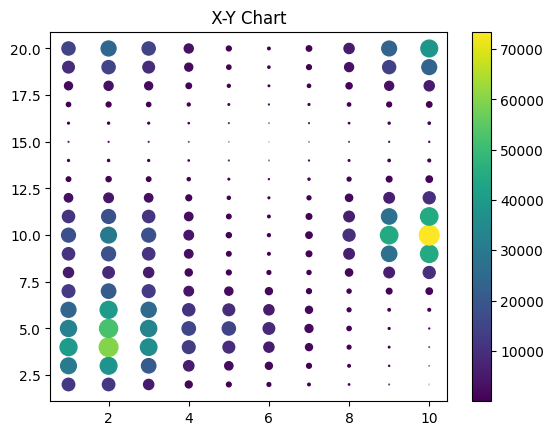

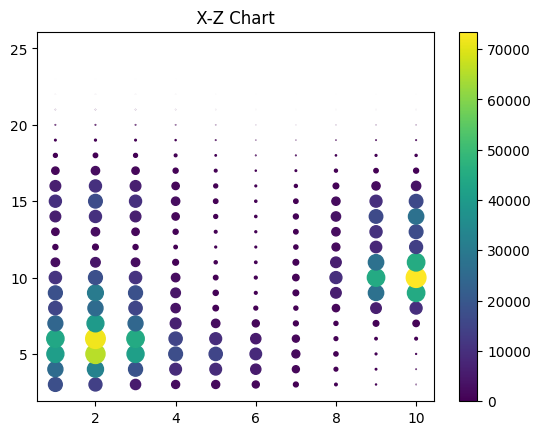

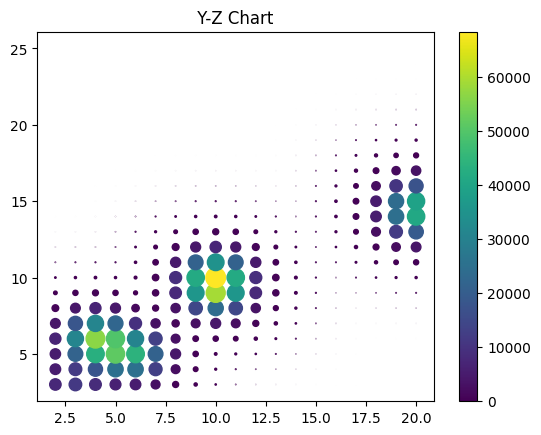

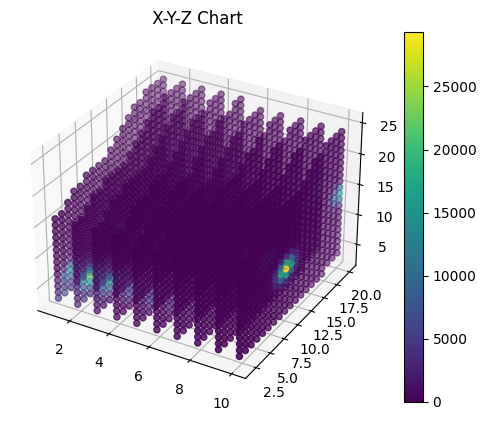

In [17]:
data = pd.DataFrame({'x': event[0], 'y': event[1], 
            'dt': event[2], 'Nel': event[3]})
# chart_scaling = 200

plotReadout(data)

In [18]:
# Initial Parameter
pitch_x = 1
pitch_y = 1
pitch_z = 1
std = det.PSFstd = 1
thresh = 1e-20
grid_size = 50
rv = multivariate_normal([0,0,0], np.diag([std, std, std]))

DriftedEvt = np.array([[1,2,3], [1,3,3], [1,3,3], [1,3,3], [5,5,5], [10,10,10],  [10,10,10], [2,4,6], [2,6,5], [10,10,10],  [10,10,10],  [10,10,10], [10,20,14], [2,20,15], [2,10,9]])
ReadoutEvt = ReadoutGain(DriftedEvt)

event = np.array(ReadoutEvt)

[1 2 3] [10 20 15]


MemoryError: Unable to allocate 22.4 GiB for an array with shape (3, 1001, 1001, 1001) and data type int64